# Word problem solver

### Modules

In [1]:
import pandas as pd
import sklearn
import json
from sklearn.model_selection import train_test_split
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs
from sentence_transformers import SentenceTransformer, util
import numpy as np
import matplotlib.pyplot as plt
import difflib
from tqdm import tqdm
import subprocess
from collections import OrderedDict, defaultdict
from bs4 import BeautifulSoup as bs
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
def avg_p(labels, preds):
    if isinstance(labels, list):
        labels = np.array(labels)
    if isinstance(preds, list):
        preds = np.array(preds)
    check = labels == preds
    invert = np.invert(check)
    return check.mean(), invert

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def try_calc(i):
    invert = np.invert(E.eval.results['trans']['invert'])
    preds = E.eval.preds[invert]
    labels = E.eval.labels[invert]
    answers = np.array(E.eval.answers)[invert]

    s = preds[i]
    print(f'Label: {labels[i]}')
    print()
    print(f'Pred: {s}')
    print()
    print(f'Correct answer = {answers[i]}')
    C = Calc()
    C.main(s)

In [3]:
class Inventory:
    def __init__(self, store=None) -> None:
        self.store = store or defaultdict(dict)

    def push(self, name, amount, prop=None):
        self.store[name][prop] = amount
    
    def get(self, name, prop=None, default=0):
        try:
            if prop:
                return self.store[name][prop]
            else:
                return sum([amount for amount in self.store[name].values()])
        except:
            return default

class Object:
    def __init__(self, idx=None, name=None, func=None, na=None, operator=None, amount=None, inventory=None, property=None) -> None:
        self.idx = idx
        self.name = name
        self.func = func
        self.na = na
        self.operator = operator
        self.amount = amount

        self.inventory = inventory or Inventory()
        self.property = property
        self.guess_preds = dict()

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.name = s[1]
        self.func = s[2]
        self.na = s[3]
        self.operator = s[4]
        self.amount = int(s[5])

class Has_part:
    def __init__(self, idx=None, agent=None) -> None:
        self.idx = idx
        self.agent = agent

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.agent = s[1]

class Property:
    def __init__(self, idx=None, name=None) -> None:
        self.idx = idx
        self.name = name

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.name = s[1]

class Modifier_pp:
    def __init__(self, idx=None, name=None, agent=None) -> None:
        self.idx = idx
        self.name = name
        self.agent = agent

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.name = s[1]
        self.agent = s[2]

class Predicate:
    def __init__(self, idx=None, action=None, agents=[], modifier_pp=None) -> None:
        self.idx = idx
        self.action = action
        self.agents = agents
        self.n_agents = len(agents)

        self.modifier_pp = modifier_pp or OrderedDict()

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.action = s[1]
        self.agents = s[2:]
        self.n_agents = len(self.agents)

class Relation:
    def __init__(self, agent1=None, link=None, agent2=None) -> None:
        self.agent1 = agent1
        self.link = link
        self.agent2 = agent2

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.agent1 = s[0]
        self.link = s[1]
        self.agent2 = s[2]

class Condition:
    def __init__(self, pre=None, post=None) -> None:
        self.pre = pre
        self.post = post

class Query:
    def __init__(self, idx=None, qtype=None, objects=OrderedDict(), predicate=Predicate(), ans='No ans') -> None:
        self.idx = idx
        self.qtype = qtype
        self.objects = objects
        self.predicate = predicate
        
        self.ans = ans


    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.qtype = s[1]

class Calc:
    def __init__(self) -> None:
        self.objects = OrderedDict()
        self.predicates = OrderedDict()
        self.relations = OrderedDict()
        self.order = []
        self.conditions = []
        self.queries = [Query()]

    def find_next_question(self, lines, i):
        try:
            q_i = lines[i:].index('QUESTION')
            return i + q_i + 1
        except ValueError:
            return 0

    def parse_queries(self, lines, i):
        queries = []
        next_question = self.find_next_question(lines, i)
        while next_question:
            queries.append(self.parse_query(lines[i:next_question]))
            i = next_question
            next_question = self.find_next_question(lines, i)
        queries.append(self.parse_query(lines[i:]))
        return queries

    @staticmethod
    def parse_query(lines):
        q = Query()
        for line in lines:
            if 'query' in line:
                q.parse(line)
            elif 'object' in line:
                ob = Object()
                ob.parse(line)
                q.objects[ob.idx] = ob
            elif 'predicate' in line:
                pr = Predicate()
                pr.parse(line)
                q.predicate = pr
            elif 'property' in line:
                prop = Property()
                prop.parse(line)
                q.objects[prop.idx].property = prop.name
        return q

    def parse_drspp(self, lines):
        conditional = False
        for i, line in enumerate(lines):
            if '[' in line:
                context_ids = line.strip()[1:-1].split(',')
                self.order.append(context_ids)
            elif 'object' in line:
                ob = Object()
                ob.parse(line)
                self.objects[ob.idx] = ob
            elif 'has_part' in line:
                hp = Has_part()
                hp.parse(line)
                ob = self.objects[hp.idx]
                self.objects[hp.agent] = Object(idx=hp.idx, name=ob.name, func=ob.func, na=ob.func, operator=ob.operator, amount=1, inventory=ob.inventory, property=ob.property)
            elif 'predicate' in line:
                pr = Predicate()
                pr.parse(line)
                self.predicates[pr.idx] = pr
            elif 'relation' in line:
                rel = Relation()
                rel.parse(line)
                self.relations[rel.agent1] = rel
            elif 'property' in line:
                prop = Property()
                prop.parse(line)
                self.objects[prop.idx].property = prop.name
            elif 'modifier_pp' in line:
                mod_pp = Modifier_pp()
                mod_pp.parse(line)
                self.predicates[mod_pp.idx].modifier_pp[mod_pp.name] = mod_pp
            if conditional:
                post = self.order.pop()
                pre = self.order.pop()
                condition = Condition(pre=pre, post=post)
                self.conditions.append(condition)
                conditional = False
            if '=>' in line:
                conditional = True
            elif 'QUESTION' in line:
                self.queries = self.parse_queries(lines, i+1)
                break

    def ape_lxml(self, text, show_output=False, raise_error=True):
        _, soup = ape(text, show_output=show_output, raise_error=raise_error)
        lines = soup.find('drspp').text.splitlines()
        lines = [line.strip() for line in lines]
        self.parse_drspp(lines)

    @staticmethod
    def get_ob_name_amount(object):
        ob_name = object.name
        ob_amount = object.amount
        ob_prop = object.property
        return ob_name, ob_amount, ob_prop

    def action_have(self, objects, pr):
        [a, b] = pr.agents
        ob_name, ob_amount, ob_prop = self.get_ob_name_amount(objects[b])
        objects = self._add(objects, [a], ob_name, ob_amount, ob_prop)
        mod_pp = pr.modifier_pp
        if len(mod_pp):
            if 'with' in mod_pp:
                c = mod_pp['with'].agent
                ob_name_c, ob_amount_c, ob_prop_c = self.get_ob_name_amount(objects[c])
                objects = self._add(objects, [a], ob_name_c, ob_amount_c, ob_prop_c)
            else:
                raise NotImplementedError(f'mod_pp.name={mod_pp.keys()}')
        return objects

    def _exhange(self, objects, agents, ob_name, ob_amount, ob_prop):
        [a, c] = agents
        inventory_a = objects[a].inventory
        inventory_c = objects[c].inventory
        inventory_ia = inventory_a.get(ob_name, ob_prop) - ob_amount
        inventory_ic = inventory_c.get(ob_name, ob_prop) + ob_amount
        inventory_a.push(ob_name, inventory_ia, ob_prop)
        inventory_c.push(ob_name, inventory_ic, ob_prop)
        objects[a].inventory = inventory_a
        objects[c].inventory = inventory_c
        return objects

    def _add(self, objects, agents, ob_name, ob_amount, ob_prop):
        [a] = agents
        inventory_a = objects[a].inventory
        inventory_ia = inventory_a.get(ob_name, ob_prop) + ob_amount
        inventory_a.push(ob_name, inventory_ia, ob_prop)
        objects[a].inventory = inventory_a
        return objects
    
    def _remove(self, objects, agents, ob_name, ob_amount, ob_prop):
        [a] = agents
        inventory_a = objects[a].inventory
        inventory_ia = inventory_a.get(ob_name, ob_prop) - ob_amount
        inventory_a.push(ob_name, inventory_ia, ob_prop)
        objects[a].inventory = inventory_a
        return objects

    def action_give(self, objects, pr):
        [a, b] = pr.agents[:2]
        ob_name, ob_amount, ob_prop = self.get_ob_name_amount(objects[b])
        mod_pp = pr.modifier_pp
        if len(mod_pp) == 1:
            c = mod_pp[list(mod_pp.keys())[0]].agent
        else:
            c = pr.agents[2]
        objects = self._exhange(objects, [a, c], ob_name, ob_amount, ob_prop)
        return objects

    def action_take(self, objects, pr):
        [a, b] = pr.agents
        mod_pp = pr.modifier_pp
        if len(mod_pp) == 1:
            c = mod_pp[list(mod_pp.keys())[0]].agent
        else:
            c = self.relations[b].agent2
        ob_name, ob_amount, ob_prop = self.get_ob_name_amount(objects[b])
        objects = self._exhange(objects, [c, a], ob_name, ob_amount, ob_prop)
        return objects

    def action_get(self, objects, pr, c=None):
        [a, b] = pr.agents
        ob_name, ob_amount, ob_prop = self.get_ob_name_amount(objects[b])
        mod_pp = pr.modifier_pp
        if len(mod_pp):
            if 'from' in mod_pp:
                c = mod_pp['from'].agent
                objects = self._exhange(objects, [c, a], ob_name, ob_amount, ob_prop)
            elif 'for' in mod_pp:
                c = mod_pp['for'].agent
                ob_name_c, ob_amount_c, ob_prop_c = self.get_ob_name_amount(objects[c])
                objects = self._add(objects, [a], ob_name, ob_amount, ob_prop)
                objects = self._remove(objects, [a], ob_name_c, ob_amount_c, ob_prop_c)
            else:
                raise NotImplementedError(f'mod_pp.name={mod_pp.name}')
        
            
        else:
            objects = self._add(objects, [a], ob_name, ob_amount, ob_prop)

        return objects

    def action_flee(self, objects, pr):
        [b] = pr.agents
        ob_name, ob_amount, ob_prop = self.get_ob_name_amount(objects[b])
        mod_pp = pr.modifier_pp
        if len(mod_pp) == 1:
            mod_pp = mod_pp[list(mod_pp.keys())[0]]
            if mod_pp.name == 'from':
                a = mod_pp.agent
            else:
                raise NotImplementedError(f'mod_pp.name={mod_pp.name}')
        
            objects = self._remove(objects, [a], ob_name, ob_amount, ob_prop)
        else:
            raise NotImplementedError
        return objects

    def action_remove(self, objects, pr):
        [a, b] = pr.agents
        ob_name, ob_amount, ob_prop = self.get_ob_name_amount(objects[b])
        objects = self._remove(objects, [a], ob_name, ob_amount, ob_prop)
        return objects

    def action_guess_pred(self, objects, pr):

        [a, b] = pr.agents
        try:
            objects = self.action_have(objects, pr)
        except:
            pass
        # ob_name, ob_amount, ob_prop = self.get_ob_name_amount(objects[b])
        # objects[a].guess_pred[pr.action] = objects[b]
        return objects



    def classify_action(self, objects, pr, guess_pred=True):
        action = pr.action
        if action == 'have' or action == 'work' or action == 'bake' or action == 'run' or action == 'need' or action == 'want':
            objects = self.action_have(objects, pr)
        elif action == 'give' or action == 'place':
            objects = self.action_give(objects, pr)
        elif action == 'take' or action == 'remove':
            objects = self.action_take(objects, pr)
        elif action == 'get' or action == 'buy' or action == 'steal' or action == 'find':
            objects = self.action_get(objects, pr)
        elif action == 'sell' or action == 'lose':
            objects = self.action_remove(objects, pr)
        elif action == 'flee':
            objects = self.action_flee(objects, pr)
        else:
            if guess_pred:
                print(f'Guessing pred for "{action}"')
                self.action_guess_pred(objects, pr)
            else:
                raise NotImplementedError(action)
        
        return objects

    def run_predicates(self, objects={}, predicates={}, order=[], update_objects=True, agent_a=None):
        objects = self.objects or objects
        predicates = self.predicates or predicates
        order = order or self.order
        for idx in order:
            for _, pr in predicates.items():
                if pr.idx in idx:
                    if agent_a and agent_a not in pr.agents:
                        pr.agents[0] = agent_a
                    objects = self.classify_action(objects, pr)
        if update_objects:
            self.objects =  objects
        return objects

    def action_val_have(self, objects, pr):
        [a, b] = pr.agents
        ob_name, ob_amount, ob_prop = self.get_ob_name_amount(objects[b])
        amount = self.objects[a].inventory.get(ob_name, ob_prop)
        amount = amount // ob_amount
        return amount

    def classify_val_action(self, objects, pr):
        action = pr.action
        if action == 'have' or action == 'work' or action == 'bake' or action == 'run' or action == 'need':
            amount = self.action_val_have(objects, pr)
        else:
            raise NotImplementedError(action)
        
        return amount

    def validate_predicates(self, predicates, objects:dict=None, agent_a=None):
        objects = objects or self.objects
        amounts = []
        for pr in predicates:
            if agent_a:
                pr.agents[0] = agent_a
            amounts.append(self.classify_val_action(objects, pr))
        return min(amounts)
                        
    def calc_cond_amount(self, order:list):
        amounts = []
        v_preds = None
        objs = [self.objects.get(idx) for idx in order if idx in self.objects]
        preds = [self.predicates.get(idx) for idx in order if idx in self.predicates]
        if len(preds):
            v_preds = self.validate_predicates(preds)
        for ob in objs:
                name = ob.name
                for order_i in self.order:
                    for f_idx in order_i:
                        f_ob = self.objects.get(f_idx, None)
                        if not f_ob:
                            continue
                        if f_ob.name == name:
                            amount = f_ob.amount//ob.amount
                            if v_preds:
                                amount = min(v_preds, amount)
                            amounts.append((f_idx, amount))
                        if name in f_ob.inventory.store:
                            inv_amount = f_ob.inventory.get(name)
                            amount = inv_amount//ob.amount
                            if v_preds:
                                amount = min(v_preds, amount)
                            amounts.append((f_idx, amount))
        return amounts
             

    def run_conditions(self, conditions=[]):
        conditions = self.conditions or conditions
        for condition in conditions:
            amounts = self.calc_cond_amount(condition.pre)
            if len(amounts):
                for (agent_a, amount) in amounts:
                    for _ in range(amount):
                        self.run_predicates(order=condition.post, agent_a=agent_a)

    def q_action_have(self, objects, query):
        [a,b] = query.predicate.agents
        ob_name, _, ob_prop = self.get_ob_name_amount(query.objects[b])
        
        '''Problem: Query agent (a) could be not referring to story. /A year has 52 weeks. How many weeks does a year have?/'''
        try:
            answer = objects[a].inventory.get(ob_name, ob_prop)
        except:
            ob_name_x, _, _ = self.get_ob_name_amount(query.objects[a])
            obs = [idx for idx, ob in objects.items() if ob.name == ob_name_x]
            idx = obs[0]
            answer = objects[idx].inventory.get(ob_name, ob_prop)
        if ob_prop:
            query.ans = {'ans': answer, 'prop': f'{ob_prop} {ob_name}'}
        else:
            query.ans = {'ans': answer, 'prop': ob_name}
        return query.ans

    def q_action_howm(self, objects, query):
        action = query.predicate.action
        if action in ['have', 'work', 'bake', 'run', 'need', 'buy', 'get', 'read']:
            answer = self.q_action_have(objects, query)
        else:
            raise NotImplementedError(action)
            answer = None
        return answer
    
    def run_queries(self, objects=None, queries=None):
        objects = self.objects or objects
        queries = self.queries or queries
        answers = []
        for query in queries:
            if query.qtype == 'howm':
                answers.append(self.q_action_howm(objects, query))
            else:
                print(f'Missing query qtype {query.qtype}')
        return answers

    def main(self, text, show_output=False, print_answers=True, raise_error=True):
        self.ape_lxml(text, show_output=show_output, raise_error=raise_error)
        self.run_predicates()
        self.run_conditions()
        answers = self.run_queries()
        if print_answers:
            for i, answer in enumerate(answers):
                print(f'Q{i}: answer = {answer["ans"]} {answer["prop"]}')
        answers = [ans['ans'] for ans in answers]
        return answers

In [4]:
class Eval:
    def __init__(self, model, labels=None, preds=None, answers=None) -> None:
        self.model = model
        self.labels = labels
        self.preds = preds
        self.answers = answers
        self.ace_true = None
        self.results = None

    def predict_word_problems(self, df):
        labels = np.array(df['target_text'].tolist())
        input_text = df['input_text'].tolist()
        preds = np.array(self.model.predict(input_text))
        input_text = np.array(input_text)
        self.labels = labels
        self.preds = preds

    def predict_gsm8k(self, fp, n=None):
        with open(fp, 'r') as json_file:
            json_list = list(json_file)
        if n:
            json_list = json_list[:n]
        labels = []
        answers = []
        for json_str in json_list:
            result = json.loads(json_str)
            labels.append(result['question'])
            answer = result['answer']
            answer = answer.split('####')[1].strip()
            answers.append(answer)
        preds = np.array(self.model.predict(labels))

        self.labels = np.array(labels)
        self.preds = preds
        self.answers = answers

    def avg_p(self, labels, preds):
        if isinstance(labels, list):
            labels = np.array(labels)
        if isinstance(preds, list):
            preds = np.array(preds)
        check = labels == preds
        invert = np.invert(check)
        return check.mean(), invert

    def correct_calculation(self, preds=None, answers=None, ace_true=True):
        if preds is None:
            preds = self.preds
        else:
            preds = preds
        if answers is None:
            answers = self.answers
        else:
            answers = answers

        if ace_true and self.ace_true is not None:
            invert = self.ace_true
            preds = self.preds[invert]
            answers = np.array(self.answers)[invert]
    
        preds_ans = []
        assert len(preds) == len(answers)

        for i, pred in enumerate(tqdm(preds, desc='calculation')):
            C = Calc()
            try:
                ans = C.main(pred, print_answers=False, raise_error=True)
                if len(ans) > 1:
                    print(f'i = {i}')
                    print(f'pred: {pred}')
                    print(f'ans: {ans}')
                    raise Exception(f'Found {len(ans)} answers')
                else:
                    ans = ans[0]
            except:
                ans = None
            preds_ans.append(ans)
        
        ans, invert = self.avg_p(answers, preds_ans)
        df = pd.DataFrame(zip(preds_ans, answers, invert), columns=['pred', 'correct', 'invert'])
        ans_total = (len(answers)*ans) / len(self.answers)

        return {'ans': ans, 'ans_total': ans_total,'invert': invert, 'df': df}
        
    def correct_ace_translation(self, preds=None):
        if preds is None:
            preds = self.preds
        else:
            preds = preds

        invert = []
        problems = []
        for i, pred in enumerate(tqdm(preds, desc='ace translation')):
            check, messages = ape(pred, show_output=False, raise_error='return')
            if check:
                invert.append(False)
            else:
                for m in messages:
                    d = dict(m.attrs.items())
                    d['pred'] = pred
                    d['idx'] = i
                    problems.append(d)
                invert.append(True)
                
        avg_p = 1-np.mean(invert)
        invert = np.array(invert)

        df = pd.DataFrame(zip(preds, invert), columns=['pred', 'invert'])
        problems = pd.DataFrame(problems)
        self.ace_true = np.invert(invert)

        return {'ans': avg_p, 'invert': invert, 'df': df, 'problems': problems}

    def semantic_similarity(self, labels=None, preds=None):
        if preds is None:
            preds = self.preds
        else:
            preds = preds
        if labels is None:
            labels = self.labels
        else:
            labels = labels
        
        model = SentenceTransformer('stsb-roberta-large')
        scores = []
        for (label, pred) in tqdm(list(zip(labels, preds)), desc='semantic similarity'):
            # encode sentences to get their embeddings
            embedding1 = model.encode(label, convert_to_tensor=True)
            embedding2 = model.encode(pred, convert_to_tensor=True)
            # compute similarity scores of two embeddings
            cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
            scores.append(cosine_scores.item())
        mean = np.mean(scores)
        return {'ans': mean, 'scores': scores}

    def string_similarity(self, labels=None, preds=None, f=levenshteinDistance):
        if preds is None:
            preds = self.preds
        else:
            preds = preds
        if labels is None:
            labels = self.labels
        else:
            labels = labels
    
        distances = []
        for (label, pred) in tqdm(list(zip(labels, preds)), desc='string similarity'):
            distance = f(label, pred)
            distances.append(distance)

        mean = np.mean(distances)
        return {'ans': mean, 'distances': distances}

    def full_report(self, labels=None, preds=None, answers=None, ace_true=True, f=levenshteinDistance):
        
        trans = self.correct_ace_translation(preds=preds)
        calc = self.correct_calculation(answers=answers, ace_true=ace_true)
        sem = self.semantic_similarity(labels=labels, preds=preds)
        string = self.string_similarity(labels=labels, preds=preds, f=f)

        print(f'correct calculation = {calc["ans"]}, total = {calc["ans_total"]}')
        print(f'correct ace translation = {trans["ans"]}')
        print(f'semantic similarity = {sem["ans"]}')
        print(f'string similarity = {string["ans"]}')
        self.results = {'calc':calc, 'trans':trans, 'sem':sem, 'string':string}
        return self.results

    def create_plots(self, results=None, bins=100):
        if results is None:
            if self.results is None:
                raise 'Results are missing!'
            results = self.results
        else:
            results = results

        # Correct translation
        y = results['trans']['ans']
        y = [y, 1-y]
        plt.pie(y, labels=['Correct', 'False'], autopct='%1.1f%%')
        plt.title('ACE compliance')
        plt.show()

        y = results['trans']['problems']
        pd.DataFrame(y[['importance', 'type']].value_counts(), columns=['Problems']).plot.pie(subplots=True,  autopct='%1.1f%%', legend=False)

        # Semantic similarity
        y = results['sem']['scores']
        pd.DataFrame(y, columns=['Semantic similarity']).hist(bins=bins)

        # String similarity
        y = results['string']['distances']
        pd.DataFrame(y, columns=['Edit distance']).hist(bins=bins)

    def difference(self, labels, preds, show_output=True):
        cases = zip(preds, labels)
        outputs = []
        for a,b in cases:
            output = ['pred  : {}\n=>\nlabel : {}'.format(a,b)]
            if show_output:     
                print(output[0])
            del_word = []
            add_word = []
            for i,s in enumerate(difflib.ndiff(a, b)):
                if s[0]==' ':
                    if len(del_word):
                        output.append("".join(del_word))
                    if len(add_word):
                        output.append("".join(add_word))
                    if show_output:
                        if len(del_word):
                            print("".join(del_word))
                        if len(add_word):
                            print("".join(add_word))
                    del_word = []
                    add_word = []
                    continue
                elif s[0]=='-':
                    if not len(del_word):
                        del_word.append(f'-- {i} : ')
                    del_word.append(s[-1])
                elif s[0]=='+':
                    if not len(add_word):
                        add_word.append(f'++ {i} : ')
                    add_word.append(s[-1])
            outputs.append("\n".join(output))
            if show_output:
                print()
        return outputs

    def calculate_difference(self, labels, preds,f=avg_p, lower=False, show_output=False):
        if isinstance(labels, list):
            labels = np.array(labels)
        if isinstance(preds, list):
            preds = np.array(preds)
        if lower:
            labels = np.char.lower(labels)
            preds = np.char.lower(preds)
        
        score, mask = f(self, labels=labels, preds=preds)
        print(score)
        outputs = self.difference(labels[mask], preds[mask], show_output=show_output)
        print(f'- {f.__name__}: {score}')
        return outputs, mask

    def custom_eval(self, df, f=avg_p, lower=False):
        labels = np.array(df['target_text'].tolist())
        input_text = df['input_text'].tolist()
        preds = np.array(self.model.predict(input_text))
        input_text = np.array(input_text)
        outputs, mask = self.calculate_difference(labels, preds, f=f, lower=lower, show_output=False)
        return outputs, labels, preds, mask

    def eval_train_test(self, train_df, test_df, lower=False):
        print('Eval train:')
        outputs_train, labels_train, preds_train, mask_train = self.custom_eval(train_df, lower=lower)
        print('\nEval test:')
        outputs_test, labels_test, preds_test, mask_test = self.custom_eval(test_df, lower=lower)
        return {"train":{"outputs":outputs_train, "labels":labels_train, "preds":preds_train, "mask":mask_train},\
               "test":{"outputs":outputs_test, "labels":labels_test, "preds":preds_test, "mask":mask_test}}

In [5]:
def console(cmnd, cwd='.', show_output=True, raise_error=True):
    try:
        output = subprocess.check_output(
            cmnd, stderr=subprocess.STDOUT, shell=True, cwd=cwd,
            universal_newlines=True)
    except subprocess.CalledProcessError as exc:
        if show_output:
            print("Status : FAIL", exc.returncode, exc.output)
        if raise_error:
            raise Exception("Error")
        return exc.returncode
    else:
        output = output.strip()
        if show_output:
            print("Output: \n{}\n".format(output))
        return output 

def print_errors(messages):
    for m in messages:
        for k, v in m.attrs.items():
            print(f' {k}: {v}')
        print()

def ape_console(text, attributes='-cdrspp -guess', cwd='APE-master', show_output=True):
    if '"' in text:
        print('found ", removing it from string')
        text = text.replace('"', '')
    output = console(f'./ape.exe -text "{text}" {attributes}', show_output=show_output, cwd=cwd)
    return output

def ape(text, attributes='-cdrspp -guess', cwd='APE-master', show_output=True, raise_error='print'):
    output = ape_console(text, attributes=attributes, show_output=show_output, cwd=cwd)
    soup = bs(output, "lxml")
    messages = soup.find_all('message')
    drspp = soup.find_all('drspp')[0].text.lower()
    
    if raise_error and len(messages):
        if raise_error == 'print':
            print_errors(messages)
        if 'no conditions' in drspp:
            if raise_error == 'return':
                return 0, messages
            raise ValueError(f"Found {len(messages)} errors")
    return 1, soup

# ape('Fabian has 3 apples.')

In [6]:
class Experiment: 
    # def __init__(self, model_name="20211207153056", model_path="/home/fabian/Documents/2021-2022/word-problem-solver/Experiments/models/", use_cuda=True) -> None:
    def __init__(self, model_name="fabianafatsawo/math_problem_NLtoACE_BART", model_path="", use_cuda=True) -> None:
        self.model = self.init_model(model_name, model_path, use_cuda)
        self.prefix = "nltocl:"
        self.eval = Eval(model=self.model)

    def init_model(self, model_name, model_path, use_cuda=True):
        # Model arguments
        model_args = Seq2SeqArgs()

        model_args.num_return_sequences = 1
        model_args.max_length = 256
        model_args.top_k = 50
        model_args.top_p = 0.95

        model_args.wandb_project = "NL to CL with BART"
        model = Seq2SeqModel(
            encoder_decoder_type="bart",
            encoder_decoder_name=model_path+model_name,
            args=model_args,
            use_cuda=use_cuda
        )
        return model

    def predict(self, problems):
        if isinstance(problems, str):
            problems = [problems]
        return self.model.predict(problems)

    def calculate(self, problems, show_output=False, print_answers=True, raise_error='print'):
        if isinstance(problems, str):
            problems = [problems]
        predictions = self.predict(problems)
        solutions = []
        for i, pred in enumerate(predictions):
            C = Calc()
            print(f'label: {problems[i]}')
            print(f'prediction: {pred}')
            solution = C.main(pred, show_output=show_output, print_answers=print_answers, raise_error=raise_error)
            solutions.append(solution)
        
        return solutions


### Trial calculation example

In [8]:
E = Experiment(model_name="fabianafatsawo/math_problem_NLtoACE_BART") 

Downloading: 100%|██████████| 1.67k/1.67k [00:00<00:00, 615kB/s]
Downloading: 100%|██████████| 532M/532M [01:14<00:00, 7.46MB/s] 
Downloading: 100%|██████████| 780k/780k [00:00<00:00, 1.54MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 934kB/s] 
Downloading: 100%|██████████| 1.29M/1.29M [00:01<00:00, 859kB/s]
Downloading: 100%|██████████| 353/353 [00:00<00:00, 68.4kB/s]


In [9]:
E.calculate(['A man has 2 apples. How many apples does the man have?'])

Generating outputs: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


label: A man has 2 apples. How many apples does the man have?
prediction: A man has 2 apples. How many apples does the man have?
Q0: answer = 2 apple


[[2]]

## Loading custom dataset

In [7]:
data_dir = 'data/ACE - Word Problems/'
fp = data_dir+'ACE - Word Problems - Present Simple 2.csv'
# fp = data_dir+'gen_4_pairs.csv'
df = pd.read_csv(fp)
df.head()

,index,problem,answer
0,1.1.1,A man has 3 apples. A woman gives 4 apples to ...,7
1,1.1.2,A woman has 1 ball. A man gives 9 balls to the...,10
2,1.1.3,A boy has 8 bananas. A girl gives 1 banana to ...,9
3,1.1.4,A girl has 3 melons. A boy gives 6 melons to t...,9
4,1.2.1,A restaurant has 175 normal chairs. The restau...,195


### Training and Test set

In [53]:
data_dir = 'data/ACE - Word Problems/'
df = pd.read_csv(data_dir+'gen_4_pairs.csv')
df["prefix"] = "nltocl"
df = df[["prefix", "input_text", "target_text"]]
q_train, q_test = train_test_split(df, random_state=10)
print(q_train.shape, q_test.shape)
q_train.head()

(513, 3) (171, 3)


,prefix,input_text,target_text
647,nltocl,There are 5 cars. If there is a car then it ne...,There are 5 cars. If there is a car then it ne...
231,nltocl,A rabbit has 2 holes with 8 carrots in each ho...,A rabbit has 2 holes with 8 carrots in each ho...
100,nltocl,A man had 20 euros. He lost 10 euros. How many...,A man has 20 euros. He loses 10 euros. How man...
278,nltocl,A school has 50 boys in the classroom. 90 girl...,A school has 50 male students. The school has ...
254,nltocl,A boy has 8 bananas. A girl gives 1 banana to ...,A boy has 8 bananas. A girl gives 1 banana to ...


In [55]:
E = Experiment(model_name="20220124114420") 
E.eval.eval_train_test(q_train, q_test, lower=False)

Eval train:


Generating outputs: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


0.7017543859649122
- avg_p: 0.7017543859649122

Eval test:


Generating outputs: 100%|██████████| 22/22 [00:09<00:00,  2.34it/s]

0.631578947368421
- avg_p: 0.631578947368421


{'train': {'outputs': ['pred  : A rabbit has 2 holes with 8 carrots in each hole. A child has 2 pockets with 2 carrots in Each pocket. The child loses 1 carrot and the rabbit finds the carrot. How many carrots does the rabbit have?\n=>\nlabel : A rabbit has 2 holes with 8 carrots in each hole. A child has 2 pockets with 2 carrots in each pocket. The child loses 1 carrot and the rabbit finds the carrot. How many carrots does the rabbit have?\n-- 90 : E\n++ 91 : e',
   'pred  : There is a mother. There is a father. A bottle has 6 glasses. If a bottle has 2 glasses then the father gets 1 glass from the bottle and the mother gets 1 Glass from the Bottle. How many glasses does the mother have?\n=>\nlabel : There is a mother. There is a father. A bottle has 6 glasses. If a bottle has 2 glasses then the father gets 1 glass from the bottle and the mother gets 1 glass from the bottle. How many glasses does the mother have?\n-- 155 : G\n++ 156 : g\n-- 171 : B\n++ 172 : b',
   'pred  : There is a

### GSM8K test

In [26]:
E = Experiment(model_name="20220124114420") 

In [9]:
E.eval.predict_gsm8k('/home/fabian/Documents/2021-2022/word-problem-solver/Experiments/grade-school-math-master/grade_school_math/data/train.jsonl')

Generating outputs: 100%|██████████| 935/935 [13:30<00:00,  1.15it/s]


In [ ]:
exp = E.eval.full_report()

In [32]:
df = exp['trans']['problems']
exp['trans']['invert']

array([ True, False,  True, ...,  True,  True,  True])

array([<AxesSubplot:ylabel='repair'>], dtype=object)

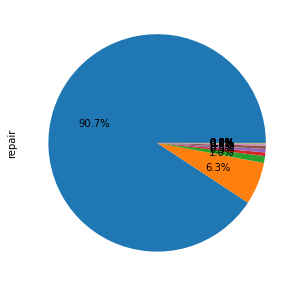

In [45]:
repair = df.loc[df['importance'] == 'error']

pd.DataFrame(repair[['repair']].value_counts(), columns=['repair']).plot.pie(subplots=True,  autopct='%1.1f%%', legend=False, figsize=(11,5), labeldistance=None)

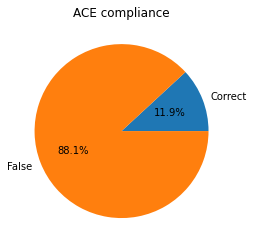

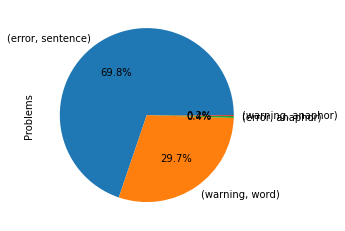

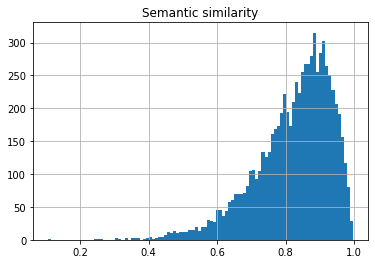

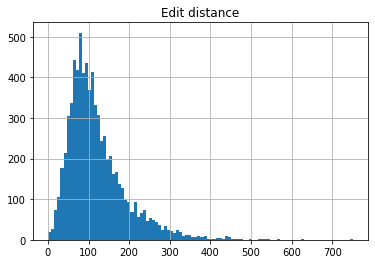

In [11]:
E.eval.create_plots()

In [21]:
try_calc(9)

Label: Carly collected 7 starfish with 5 arms each and one seastar with 14 arms. How many arms do the animals she collected have in total?

Pred: A woman has 7 starfish with 5 arms. She has 1 seastar with 14 arms. How many arms do the women have?

Correct answer = 49
Q0: answer = 19 arm


In [67]:
s = "A girl has 5 boxes with 50 marbles in each box. \
    The girl gets 20 marbles from a friend. \
    How many marbles does she have? \
    How many marbles does the girl have?"
C = Calc()
C.main(s)

Q0: answer = -20 marble
Q1: answer = 270 marble


[-20, 270]

## Custom data experiment

### Present Tense

ace translation:  80%|████████  | 64/80 [00:15<00:03,  4.52it/s]

found ", removing it from string


calculation:  85%|████████▌ | 58/68 [00:16<00:04,  2.05it/s]

found ", removing it from string


string similarity: 100%|██████████| 80/80 [00:00<00:00, 256.53it/s]


correct calculation = 0.7205882352941176, total = 0.6125
correct ace translation = 0.85
semantic similarity = 0.9965885199606419
string similarity = 1.6875


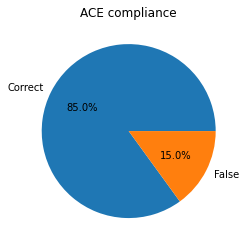

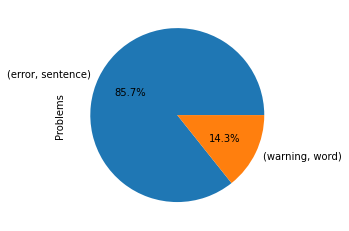

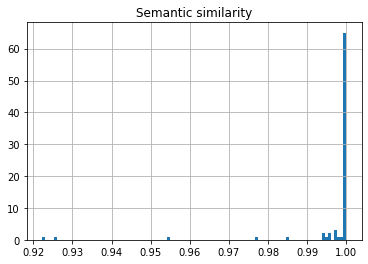

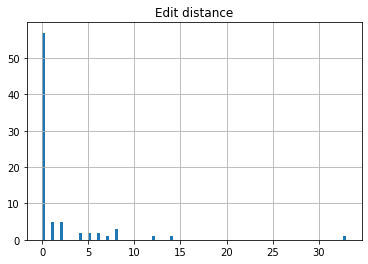

In [10]:
E2 = Experiment(model_name="20220109165331") 
# E2.eval.predict_word_problems(df)
E2.eval.preds = np.array(E.predict(list(df['problem'])))
E2.eval.labels = np.array(list(df['problem']))
E2.eval.answers = np.array(list(df['answer']))
E2.eval.full_report()
E2.eval.create_plots()

### Past Tense

ace translation:  80%|████████  | 64/80 [00:13<00:03,  4.49it/s]

found ", removing it from string


ace translation:  84%|████████▍ | 67/80 [00:14<00:02,  4.48it/s]

found ", removing it from string


calculation:  56%|█████▌    | 39/70 [00:08<00:06,  4.90it/s]

Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"
Guessing pred for "ran"


calculation:  84%|████████▍ | 59/70 [00:14<00:05,  2.18it/s]

found ", removing it from string


calculation:  89%|████████▊ | 62/70 [00:15<00:02,  3.49it/s]

found ", removing it from string


string similarity: 100%|██████████| 80/80 [00:00<00:00, 252.35it/s]


correct calculation = 0.7142857142857143, total = 0.625
correct ace translation = 0.875
semantic similarity = 0.9833081275224685
string similarity = 10.45


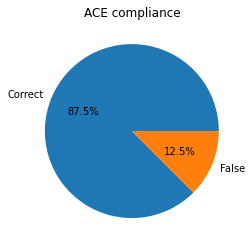

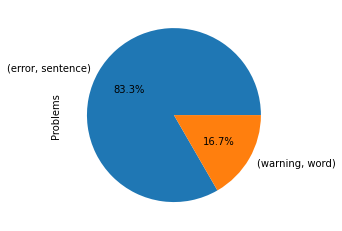

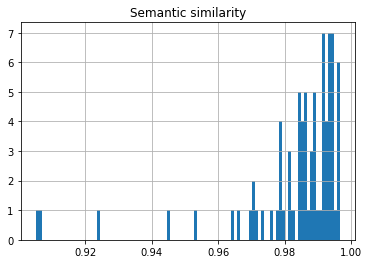

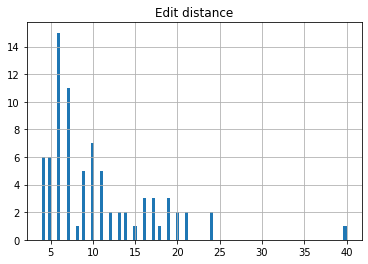

In [9]:
data_dir = 'data/ACE - Word Problems/'
fp = data_dir+'ACE - Word Problems - Past Simple.csv'
# fp = data_dir+'gen_4_pairs.csv'
df = pd.read_csv(fp)
df.head()

E2 = Experiment(model_name="20220124114420") 
# E2.eval.predict_word_problems(df)
E2.eval.preds = np.array(E.predict(list(df['problem'])))
E2.eval.labels = np.array(list(df['problem']))
E2.eval.answers = np.array(list(df['answer']))
E2.eval.full_report()
E2.eval.create_plots()